In [18]:
#Dependencies
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import math
import string
import copy
import torch.nn as nn
from collections import Counter

# #Read the sentences in seperate text files
# with open ('short_nep//nep_337_21_nov.txt', 'r', encoding="utf-8") as f:
#     short_nepali_txt = f.read()
    
# with open ('short_nep//short_eng_nep_nov_21.txt', 'r', encoding="utf-8") as f:
#     short_eng_txt = f.read() 

In [3]:
#No unknown tokens are used here
#specify language -- start and end tokens are appended accordingly
#Vocab indices start from 1, 0 is saved for padding missing words in short sentences
#ALL THE ADDITION OR DELITIONS OF SENTENCES SHOULD BE SYMMETRIC --> OCCURING TOGETHER IN BOTH CORPUS

def pre_process(raw_text, lang):
    
    
    no_quotes = ''.join(ch for ch in raw_text if ch not in set(string.punctuation))
    
    no_quotes = no_quotes[1:]  #replaces ("\ufeff") --> a single character
    
    if lang == 'nep':
        no_quotes = no_quotes.replace("|'", '')
        
    else:
        no_quotes = no_quotes.lower()   #all english words in lower case
    
    split_sents = no_quotes.split('\n') #makes one single list of sentences
    
    
    sent_list = [[i] for i in split_sents] #Make a seperate sublist within a list
    
    words_in_sent = [sent_list[i][0].split() for i in range(len(sent_list))] #Split each sentence into words
    words_in_sent_seos = copy.deepcopy(words_in_sent) #Make a copy without interferring the above copy 
    
    all_words = no_quotes.split() #each word in corpus is split seperately
    most_common = [item for item in Counter(all_words).most_common()]
    
    if lang == 'nep':
        words_in_sent_seos = [['एसओएस']+i for i in words_in_sent_seos] #append 'beginning of sentence token'
        [i.append('ईओएस') for i in words_in_sent_seos] #Append 'end of sentence token'
        all_words.extend(['एसओएस', 'ईओएस'])
    
    else:
        words_in_sent_seos = [['start_o_s']+i for i in words_in_sent_seos] #append 'beginning of sentence token'
        [i.append('end_o_s') for i in words_in_sent_seos] #Append 'end of sentence token'
        all_words.extend(['start_o_s', 'end_o_s'])
        
    vocab = set(all_words) # set containing all the words
    
    a_list = [i+1 for i in range(len(vocab)+1)] #list range, starts from 1, 0 index is saved for padding purpose 
    idx_2_word = dict(zip(a_list, list(vocab))) #look up dict assigning an index to each unique word
    word_2_idx = {v:k for k, v in idx_2_word.items()} #reversed mapping
    
    
    maxList = (max(words_in_sent_seos,key=len))
    maxLength = len(maxList)
    
    return (words_in_sent_seos, vocab, idx_2_word, word_2_idx, most_common, maxList, maxLength)

In [4]:
#GPU switch
import torch

use_gpu = True


if use_gpu:
    dtype = torch.cuda.FloatTensor 
else:
    dtype = torch.FloatTensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#Note we will use different sets of embedding for source and target
#Embeddings are not trained
#Here the very first embedding (0 index) is used for padding, 'pad' subsequently added to vocab
#Hence vocab +1 embedding are needed
def get_embeds(vocab, d_model):
    embeds = nn.Embedding(len(vocab)+1, d_model)
    return embeds

In [6]:
#Sentences --> seq of words --> indices --> embedding stack
#Length of each sentence is later used to develop appropriate mask --> num of words/sentence are differ 
#paddings will be used to keep sequence length the same
def sent_2_idxs(sentences, embedding, word_2_idx_dict):
    
    
    batch_tensor = torch.FloatTensor([]) #Empty tensor to get cumulate all sentence --> all word embeding
    sent_to_idx =[] #Get the corresponding integers for each word (word to index)
    num_sentences = len(sentences) #Just cache number of actual words in each sentence, needed for padding
    embedding_stack = []  #Tensors collected as lit --> Unnecessary
    
    
    max_len = len(max(sentences, key=len))
    
    
    all_zeros = [0 for i in range(max_len)] #predefine list of 0s --> simplifies padding
    len_each_sent = [len(x) for x in sentences]  #Later will be needed for padding to nullify attention weights
    
    for j in range(num_sentences):
        word_2_int = [word_2_idx_dict[i] for i in sentences[j]]   #Get indices
        word_2_int = word_2_int + all_zeros[len(word_2_int):]  #Use 0 padding, when there are < max_len words 
        
        sent_to_idx.append(word_2_int) #Collect all sentences-words as indices in a full list
        
        batch_tensor = torch.cat((batch_tensor, embedding(torch.LongTensor(word_2_int)).unsqueeze(0)), dim = 0) #Full stack tensor
        
        #This is redundant
        #embedding_stack.append(embedding_e(torch.LongTensor(word_2_int)))
    
    
    return sent_to_idx, len_each_sent, batch_tensor

In [8]:
#Get positional encodings

def pos_enc(cur_batch, d_model):
        
    num_words = cur_batch.size(1)
    
    p_cache = []  #Catch all the positional encodes for position ij
    
    pos_embs = torch.zeros(num_words, d_model)
    
    
    #pos--> position of the word
    #i --> position within the word vector
    for pos in range(num_words):
        p_cache = []
        for  i in range(d_model):
            if i%2 == 0:

                order_emb = np.sin(pos/(10000**(i/(d_model))))
                p_cache.append(order_emb)
                

            else:
                
                order_emb = np.cos(pos/(10000**(i/(d_model))))
                p_cache.append(order_emb)
                
        pos_embs[pos, :] = torch.tensor(p_cache)
    return pos_embs
    


def add_pos_enc(cur_batch):

    d_model = cur_batch.size(-1)
    get_pos_enc = pos_enc(cur_batch, d_model)
    input_add_pos = cur_batch + get_pos_enc
    return input_add_pos


#Alternative method to add positional encoding --> this doesn't require computing the encodings each time
#when  model_dim and max of sequence legth is known
d_model = 64
some_dummy = torch.arange(2*20*d_model).view(-1, 20, d_model)
ref_pos_enc = pos_enc(some_dummy, d_model).unsqueeze(0)


def add_pos_enc_alt(cur_batch):

    get_pos_enc = ref_pos_enc[0, :cur_batch.size(1), :]
    input_add_pos = cur_batch + get_pos_enc
    return input_add_pos

In [81]:
#Mask eliminates all the scores computations due to padding, where actual words were not used
#tens --> tensor
#Create pading mask when sentences in a batch have unqual length
def get_mask_by_length(len_list):
    tens_ones = torch.ones(len(len_list), max(len_list)) #all ones
    tens_multipy = tens_ones * torch.tensor(len_list).view(tens_ones.size(0), -1) # multiply by length of each
    tens_range = ([torch.arange(max(len_list)) for i in range(len(len_list))]) #returns list of tensors from 0 to max_len
    tens_range = torch.stack(tens_range) #stack them to get final tensor
    #print(tens_ones, tens_multipy, tens_range, tens_range)
    return (tens_range < tens_multipy)*1 #finally get the mask


#works only if paddings were all 0s
def get_mask_by_batch(cur_batch):
    #works only if all paddings are actually 0
    return ((torch.sum(cur_batch, dim =-1))!=0)*1

In [82]:
some_x =[1, 2, 5]
get_mask_by_length(some_x)

tensor([[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1]])

In [173]:
from torch.autograd import Variable

def init_weights(d_model, use_gpu):
    
    if use_gpu:
        Wq = Variable(torch.rand(d_model, d_model).cuda(), requires_grad=True)#, device="cuda")
        torch.nn.init.xavier_uniform_(Wq)
        Wk = Variable(torch.rand(d_model, d_model).cuda(), requires_grad=True)#, device="cuda")
        torch.nn.init.xavier_uniform_(Wk)
        Wv = Variable(torch.rand(d_model, d_model).cuda(), requires_grad=True)#, device="cuda")
        torch.nn.init.xavier_uniform_(Wv)
        Wo = Variable(torch.rand(d_model, d_model).cuda(), requires_grad=True)#, device="cuda")
        torch.nn.init.xavier_uniform_(Wv)
    else:
        Wq = Variable(torch.rand(d_model, d_model), requires_grad=True)
        torch.nn.init.xavier_uniform_(Wq)
        Wk = Variable(torch.rand(d_model, d_model), requires_grad=True)
        torch.nn.init.xavier_uniform_(Wk)
        Wv = Variable(torch.rand(d_model, d_model), requires_grad=True)
        torch.nn.init.xavier_uniform_(Wv)
        Wo = Variable(torch.rand(d_model, d_model), requires_grad=True)
        torch.nn.init.xavier_uniform_(Wv)
    return Wq, Wk, Wv, Wo


def init_FFN(d_model, int_vec_size, use_gpu):
    
    if use_gpu:
        FF1 = Variable(torch.randn(d_model, int_vec_size).cuda(), requires_grad=True)#, device="cuda")
        torch.nn.init.xavier_uniform_(FF1)
        FF2 = Variable(torch.randn(int_vec_size, d_model).cuda(), requires_grad=True)#, device="cuda")
        torch.nn.init.xavier_uniform_(FF2)
        bFF1 = Variable(torch.zeros(1, int_vec_size).cuda(), requires_grad=True)#, device="cuda")
        bFF2 = Variable(torch.zeros(1, d_model).cuda(), requires_grad=True)#, device="cuda")
        
        
    
    else:
        FF1 = Variable(torch.randn(d_model, int_vec_size), requires_grad=True)
        torch.nn.init.xavier_uniform_(FF1)
        FF2 = Variable(torch.randn(int_vec_size, d_model), requires_grad=True)
        torch.nn.init.xavier_uniform_(FF2)
        bFF1 = Variable(torch.zeros(1, int_vec_size), requires_grad=True)
        bFF2 = Variable(torch.zeros(1, d_model), requires_grad=True)
    
    return FF1, FF2, bFF1, bFF2

def init_fin_FFN(d_model, vocab, use_gpu):
    fin_vec_size = len(list(vocab)) + 1
    
    if use_gpu:
        wts = Variable(torch.randn(d_model, fin_vec_size).cuda(), requires_grad=True)
        torch.nn.init.xavier_uniform_(wts)
        biases = Variable(torch.zeros(1, fin_vec_size).cuda(), requires_grad=True)
       
    else:
        wts = Variable(torch.randn(d_model, fin_vec_size), requires_grad=True)
        torch.nn.init.xavier_uniform_(wts)
        biases = Variable(torch.zeros(1, fin_vec_size), requires_grad=True)
    
    return wts, biases



# def init_fin_FFN(d_model, vocab, use_gpu):
    
#     if use_gpu:
#         int_vec_size = len(list(vocab)) + 1
#         wts = Variable(torch.randn(d_model, int_vec_size).cuda(), requires_grad=True)
#         torch.nn.init.xavier_uniform_(wts)
#         biases = Variable(torch.zeros(1, int_vec_size).cuda(), requires_grad=True)
    
    
#     else:
#         int_vec_size = len(list(vocab)) + 1
#         wts = Variable(torch.randn(d_model, int_vec_size), requires_grad=True)#*0.001
#         torch.nn.init.xavier_uniform_(wts)
#         biases = Variable(torch.zeros(1, int_vec_size), requires_grad=True)
    
#     return wts, biases

In [161]:
# d_model = _
# heads = _
# d_k = int(d_model/heads)

#Same function is employed for encoder and decoder
#inputs are padded - and padding mask ensures all padded words will have 0 vectors
#All interaction with these pad vectors will result in values 0
#once -inf mask is applied to them --> softmax assigns 0 probailities to these values
#hence cutting off all possibilities/interactions
#src_input --> comes from encoder side, trg_inp comes from decoder side
#For encoder --> same/src_inp are passed twice
#For decoder --> first step in each layer gets trg_inp for both, second step --> gets enc_output and dec_output

#def mh_enc_dec(enc_out, dec_mmha_out, params, use_gpu, non_peek):
def mh_enc_dec(src_inp, trg_inp, params, use_gpu, non_peek):
    
    #d_k = int(d_model/heads)
    batch_size = src_inp.size(0)
    Wq, Wk, Wv, Wo = params
    
    #represent all word-embeddings as intermediate vectors
    q_vecs = trg_inp @ Wq     #Quaries come from decoder
    k_vecs = src_inp @ Wk
    v_vecs = src_inp @ Wv
    
    #reshape --> torch.Size([2, 2, 24, 15]) --> each sentence block has now h sets of int vectors --> or heads
    q_vecs = q_vecs.view(batch_size, -1, heads, d_k).transpose(1, 2)
    k_vecs = k_vecs.view(batch_size, -1, heads, d_k).transpose(1, 2)
    v_vecs = v_vecs.view(batch_size, -1, heads, d_k).transpose(1, 2)
    
    #get raw scores, each block in q is dotted with transpose respective block in k
    raw_wtss = torch.matmul(q_vecs, k_vecs.transpose(-2, -1)) /  math.sqrt(d_k)
    
    #####################################
    #Direct method of applying both pad and non_peak and not required to compute cortd_scores
    #if non_peek:
        #after_pad_n_non_peek = ((1 -(raw_wtss1==0)*1) * (non_peek_b(raw_wtss1))) * raw_wtss1 + (((((1 -(raw_wtss1==0)*1) * (non_peek_b(raw_wtss1))) * raw_wtss1)==0)*-1e9)
    ###########################################
    #get a mask with 0 or -inf where there are 0(padded) 
    #Add to raw_score then use softmax to get the attention weights
    neg_inf_mask = (raw_wtss==0)*(-1e9)
    
    #ADD NON PEAK on top of this
    cortd_scores = raw_wtss + neg_inf_mask
    
    if non_peek:
        
        cortd_scores = ((non_peek_mask(cortd_scores, use_gpu) * cortd_scores) + ((non_peek_mask(cortd_scores, use_gpu)*cortd_scores)==0)*-1e9)
    soft_wtss =nn.Softmax(dim = -1)(cortd_scores)
    
    
    
    wtd_vals = soft_wtss @ v_vecs
    wtd_vals = wtd_vals.transpose(1,2).contiguous().view(batch_size, -1, d_model) 
    
    forward_vals = wtd_vals @ Wo
    
    return forward_vals
    #return forward_vals, v_vecs

In [90]:
#position wise feed forwad
def pFFN(input_tensor, params):
    eFF1a, eFF1b, eB1a, eB1b = params
    first_lin = nn.ReLU()((input_tensor @ eFF1a) + eB1a)
    out_tensor = (first_lin @ eFF1b) + eB1b
    return out_tensor


#Final linear before softmax
def fin_linear(input_tensor, params):
    wts, biases = params
    out_tensor = (input_tensor @ wts) + biases
    return out_tensor

In [91]:
#normalize each vector
def layer_norm(x):
    
    row_mean = torch.mean(x, dim =-1)
    row_var = torch.var(x, dim =-1)
    row_std = torch.std(x, dim =-1)
    row_norm_x = (x - row_mean.view(x.size()[0], x.size(1), 1))/row_std.view(x.size()[0], x.size(1), 1)
    return row_norm_x

#Residual connection
def add_norm(original, transformed):
    added = original + transformed
    add_norm = layer_norm(added)
    return add_norm

In [92]:
#Get non peek mask, compatible with score matrix
def non_peek_mask(score_matrix, use_gpu):
    low_t = torch.tril(torch.ones(score_matrix.size()), diagonal=0).int()
    
    if use_gpu:
        return low_t.type(dtype).to(device)
    else:
        return low_t.type(torch.FloatTensor)

In [93]:
#Combining releant steps together

#For the whole corpus
#Break sentences into list of words, add 'sos' at the beginning and 'eos' at the end
#Get vocab, dictionaries of word - idx conversion, the length of longest sentence, raw embedding weigts
def process_and_embed(raw_txt, lang, d_model):
    words_in_sent_seos, vocab, idx_2_word, word_2_idx, most_common, maxList, maxLength = pre_process(raw_txt, lang)
    emb_dim = d_model
    embeds = get_embeds(vocab, d_model)
    return (words_in_sent_seos, vocab, idx_2_word, word_2_idx, most_common, maxList, maxLength, embeds)



#Get a slice of data, startig from ith index
def get_batch(i, sent_list, batch_size):
    cur_batch = sent_list[i:i+batch_size]
    return cur_batch

#shuffled_list = xxx, (randomize the total samples)
def get_batch_shuffled(i, sent_list, batch_size):
    idxs = shuffled_list[i*batch_size:i*batch_size+batch_size]
    cur_batch = list(np.array(sent_list)[idxs])
    return cur_batch


#Change the words to corresponding embedding
#Get the target (shifted) words as integers, to be used for loss computation
def get_inp_tensor(cur_batch, embeds_look_up, word_2_idx, use_gpu):
    sent_to_idx_bi, len_each_sent_bi, batch_tensor_bi = sent_2_idxs(cur_batch, embeds_look_up, word_2_idx)
    cur_inp = add_pos_enc(batch_tensor_bi)
    
    #Restore the 0 values despite embeddings/pos encodings being non 0s
    mask_using_len = get_mask_by_length(len_each_sent_bi)  ### alternative
    masked_inp = cur_inp * mask_using_len[:, :, None]
#     mask_using_batch = get_mask_by_batch(batch_tensor_bi)

    
    #targets start after sos and target for eos in longest sentence is a pad(0)
    targets = [(i[1:] + [0]) for i in sent_to_idx_bi]
    if use_gpu:
        return masked_inp.type(dtype).to(device), targets#.to(device)
        
    else:
        return masked_inp, targets

In [94]:
#compute multi-head attention using encoder
#Note multi-head for encoder has one step and does not use Non-peek mask
def compute_mha_enc(src_inp, kqv_weights, ffn_params, use_gpu):
    
    enc_mh_out = mh_enc_dec(src_inp, src_inp, kqv_weights, use_gpu, non_peek =False ) 
    add_norm_enc_mh_out = add_norm(src_inp, enc_mh_out)
    ffn_out1 = pFFN(add_norm_enc_mh_out, ffn_params)
    final_dec_out1 = add_norm(add_norm_enc_mh_out, ffn_out1)
    return final_dec_out1



#compute multi-head attention using encoder
#Note multi-head for decoder has two step and uses Non-peek mask for first step
def compute_mha_dec(trg_inp, enc_out, kqv_weights1, kqv_weights2, ffn_params, use_gpu):
    
    dec_masked_mh_out = mh_enc_dec(trg_inp, trg_inp, kqv_weights1, use_gpu, non_peek=True) 
    add_norm_dec_masked_mh_out = add_norm(trg_inp, dec_masked_mh_out)
    
    #Decoder stack is used for residual connection
    dec_multi_h_out = mh_enc_dec(enc_out, add_norm_dec_masked_mh_out, kqv_weights2, use_gpu, non_peek=False) 
    add_norm_dec_multi_h_out = add_norm(add_norm_dec_masked_mh_out, dec_multi_h_out)
    
    ffn_out = pFFN(add_norm_dec_multi_h_out, ffn_params)
    final_dec_out = add_norm(add_norm_dec_multi_h_out, ffn_out)
    return final_dec_out

In [302]:
#Initialize the key variables
#By tweaking these number --> words can be repesented as any dim, different heads and int vectors (used in pFFN)
d_model = 48  #
heads = 2
d_k = int(d_model/heads)
int_vec_size = 96
use_gpu = True

In [303]:
#d_model = 64

#Read the sentences in seperate text files
with open ('short_nep//nep_337_21_nov.txt', 'r', encoding="utf-8") as f:
    short_nepali_txt = f.read()
    
with open ('short_nep//short_eng_nep_nov_21.txt', 'r', encoding="utf-8") as f:
    short_eng_txt = f.read() 

#For both english and nepali --> get sentences, dictionaries, vocabs and embeddings
#lang = 'eng'
words_in_sent_seos_e, vocab_e, idx_2_word_e, word_2_idx_e, most_common_e, maxList_e, maxLength_e, embeds_e = \
process_and_embed(short_eng_txt, 'eng', d_model)

#Just as important
word_2_idx_e.update( {'pad' : 0} )
idx_2_word_e[0] ='pad'



#lang = 'nep'
words_in_sent_seos_n, vocab_n, idx_2_word_n, word_2_idx_n, most_common_n, maxList_n, maxLength_n, embeds_n = \
process_and_embed(short_nepali_txt, 'nep', d_model)

#Just as important
word_2_idx_n.update( {'pad' : 0} )
idx_2_word_n[0] ='pad'

In [304]:
import random

#shuffle_list cotains all the numbers from sentence 0 to end
losses = []
shuffled_list = [i for i in range(len(words_in_sent_seos_e))]
random.shuffle(shuffled_list)
shuffled_list[:10]

[286, 292, 56, 233, 329, 261, 253, 73, 109, 302]

In [305]:
# Relevant states
# d_model = _
# int_vec_size = _
# use_gpu = True/False

#Encoder parameters
params_enc_mh1 = list(init_weights(d_model, use_gpu))
params_ffn_enc_mh1 = list(init_FFN(d_model, int_vec_size, use_gpu))
params_enc_mh2 = list(init_weights(d_model, use_gpu))
params_ffn_enc_mh2 = list(init_FFN(d_model, int_vec_size, use_gpu))


#Decoder parameters
params_dec_mh1a = list(init_weights(d_model, use_gpu))
params_dec_mh1b = list(init_weights(d_model, use_gpu))
params_ffn_dec_mh1 = list(init_FFN(d_model, int_vec_size, use_gpu))
params_dec_mh2a = list(init_weights(d_model, use_gpu))
params_dec_mh2b = list(init_weights(d_model, use_gpu))
params_ffn_dec_mh2 = list(init_FFN(d_model, int_vec_size, use_gpu))


#fin layer of decoder
fin_params = list(init_fin_FFN(d_model, vocab_n, use_gpu))

In [306]:
#Make a list of all parameters
#use Adam as opitmizer
#Note initial embedding are neither pre-trained nor tied in this simple model
all_parameters = params_enc_mh1 + params_ffn_enc_mh1 + params_enc_mh2 + params_ffn_enc_mh2 + params_dec_mh1a + params_dec_mh1b + params_ffn_dec_mh1 + \
                   params_dec_mh2a + params_dec_mh2b + params_ffn_dec_mh2 + fin_params # + list(embeds_n.weight.data) + list(embeds_e.weight.data)

optimizer = torch.optim.Adam((all_parameters), lr = 0.0001)

In [307]:
from timeit import default_timer as timer
import torch.nn.functional as F


start = timer()
#ALl inputs are and weights (appropriately typed) are shifted to GPU - when GPU is preferred
# heads = _
# d_model = _
# d_k = int(d_model/heads)
# int_vec_size = _
batch_size = 48   
#random.shuffle(shuffled_list)

use_gpu = True
for j in range(100):
    for i in range(len(words_in_sent_seos_e)//batch_size):
    
        cur_batch_eng = get_batch(i, words_in_sent_seos_e, batch_size)
        cur_batch_nep = get_batch(i, words_in_sent_seos_n, batch_size)
        
        #Alternatively shuffle the input sentences
#         cur_batch_eng = get_batch_shuffled(i, words_in_sent_seos_e, batch_size)
#         cur_batch_nep = get_batch_shuffled(i, words_in_sent_seos_n, batch_size)
    
        
        masked_inp_eng, word_indices_eng = get_inp_tensor(cur_batch_eng, embeds_e, word_2_idx_e, use_gpu)

        #For encoder side --> non_peek shouldn't be applied
        final_enc_out1 = compute_mha_enc(masked_inp_eng, params_enc_mh1, params_ffn_enc_mh1, use_gpu)
        final_enc_out2 = compute_mha_enc(final_enc_out1, params_enc_mh2, params_ffn_enc_mh2, use_gpu)


        #TARGET SENTENCES
        #word_indices are the targets in context of lang that is being decoded
        #All the indices are right shifted, along with non-peek, and teacher forcing --> trains the decoder
        masked_inp_nep, word_indices_nep = get_inp_tensor(cur_batch_nep, embeds_n, word_2_idx_n, use_gpu)


        #Decoder computation
        final_dec_out1 = compute_mha_dec(masked_inp_nep, final_enc_out2, params_dec_mh1a, params_dec_mh1b, params_ffn_dec_mh1, use_gpu)
        final_dec_out2 = compute_mha_dec(final_dec_out1, final_enc_out2, params_dec_mh2a, params_dec_mh2b, params_ffn_dec_mh2, use_gpu)
        
        #From the top of the decoder        
        fin_tensor = fin_linear(final_dec_out2, fin_params)
        
        #Shifterd to GPU
        targets_nep = torch.tensor(word_indices_nep).view(-1).to(device)
        
        #loss = F.cross_entropy(fin_tensor.view(-1, fin_tensor.size(-1)), targets_nep)
        #Computes loss excluding pads
        loss_ex_pad =  F.cross_entropy(fin_tensor.view(-1, fin_tensor.size(-1)), targets_nep, ignore_index= 0)

        optimizer.zero_grad()
        loss_ex_pad.backward(retain_graph=True)
        optimizer.step()

        if i%4 ==0:
            losses.append(loss_ex_pad.item())
            
    
    if j%5 ==0:
        print(j)
        print(loss_ex_pad.item())
        

end = timer()
elapsed_time = end - start
print(end - start)

0
6.1360249519348145
5
5.505064010620117
10
5.175290584564209
15
4.913086891174316
20
4.655522346496582
25
4.393017768859863
30
4.13569450378418
35
3.8869175910949707
40
3.6489763259887695
45
3.418710947036743
50
3.1960952281951904
55
2.9813826084136963
60
2.7736191749572754
65
2.5756564140319824
70
2.389052629470825
75
2.2125189304351807
80
2.0480284690856934
85
1.895870566368103
90
1.753072738647461
95
1.6203293800354004
61.562521200001356


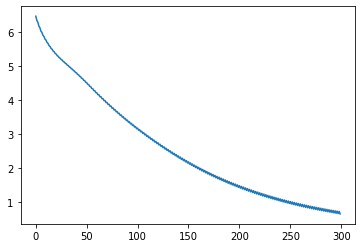

In [294]:
plt.plot(losses)

In [223]:
#Once trained, ready to translate
#Translation - Encoder computes the stack for whole source sentence
#Decoder - decodes the first word --> given encoder stack and 'nep_SOS' --> second word --> given encoder stack + 'sos' + first word....so forth
#The embedding for 'nep_sos' is used to kick start decoding
#Translation function uses the same logic except batch size is kept 1 (it's possible to translate multiple sentences at once)
batch_size = 1
def trans_2_nep(sent_num):
   
    eng_sent = get_batch(sent_num, words_in_sent_seos_e, 1)
    starter = embeds_n(torch.LongTensor([word_2_idx_n['एसओएस']])).view(1, 1, -1).type(dtype).to(device)
    masked_inp_src, word_indices_src = get_inp_tensor(eng_sent, embeds_e, word_2_idx_e, use_gpu)
    
    print(get_batch(sent_num, words_in_sent_seos_e, 1))
    for i in range(10):


        
        final_enc_out_trans1 = compute_mha_enc(masked_inp_src, params_enc_mh1, params_ffn_enc_mh1, use_gpu)
        final_enc_out_trans2 = compute_mha_enc(final_enc_out_trans1, params_enc_mh2, params_ffn_enc_mh2, use_gpu)
        

        
        final_dec_out1 = compute_mha_dec(starter, final_enc_out_trans2, params_dec_mh1a, params_dec_mh1b, params_ffn_dec_mh1, use_gpu)
        final_dec_out2 = compute_mha_dec(final_dec_out1, final_enc_out_trans2, params_dec_mh2a, params_dec_mh2b, params_ffn_dec_mh2, use_gpu)
        

        fin_tensor = fin_linear(final_dec_out2, fin_params)
        y_hat = nn.Softmax(dim =-1)(fin_tensor)
        pred_next = torch.topk(y_hat.view(-1, y_hat.size(-1)), 3)[1][i,0]
        emb_pred_word = embeds_n(torch.LongTensor([pred_next.item()])).view(1, 1, -1).type(dtype).to(device)
        starter = torch.cat((starter, emb_pred_word), dim =1)
        nepali_word = idx_2_word_n[pred_next.item()]
        print(nepali_word)
        
        
        
        if nepali_word == 'ईओएस':
            break
    return (torch.topk(y_hat.view(-1, y_hat.size(-1)), 4))  #print top indices and their probailities

In [310]:
trans_2_nep(15)

[['start_o_s', 'get', 'ready', 'to', 'eat', 'end_o_s']]
खान
तयार
हुनुहोस्
ईओएस


torch.return_types.topk(
values=tensor([[0.0595, 0.0242, 0.0202, 0.0198],
        [0.0470, 0.0294, 0.0174, 0.0135],
        [0.1360, 0.0173, 0.0131, 0.0128],
        [0.4343, 0.0351, 0.0144, 0.0124]], device='cuda:0',
       grad_fn=<TopkBackward>),
indices=tensor([[274, 192, 239, 486],
        [486, 274, 487, 192],
        [192, 273, 487, 456],
        [487, 112, 456, 273]], device='cuda:0'))

In [169]:
masked_inp_eng.shape

torch.Size([48, 8, 32])

In [163]:
def mh_enc_dec11(src_inp, trg_inp, params, use_gpu, non_peek):
    
    #d_k = int(d_model/heads)
    batch_size = src_inp.size(0)
    Wq, Wk, Wv, Wo = params
    
    #represent all word-embeddings as intermediate vectors
    q_vecs = trg_inp @ Wq     #Quaries come from decoder
    k_vecs = src_inp @ Wk
    v_vecs = src_inp @ Wv
    
    #reshape --> torch.Size([2, 2, 24, 15]) --> each sentence block has now h sets of int vectors --> or heads
    q_vecs = q_vecs.view(batch_size, -1, heads, d_k).transpose(1, 2)
    k_vecs = k_vecs.view(batch_size, -1, heads, d_k).transpose(1, 2)
    v_vecs = v_vecs.view(batch_size, -1, heads, d_k).transpose(1, 2)
    
    #get raw scores, each block in q is dotted with transpose respective block in k
    raw_wtss = torch.matmul(q_vecs, k_vecs.transpose(-2, -1)) /  math.sqrt(d_k)
    
    #####################################
    #Direct method of applying both pad and non_peak and not required to compute cortd_scores
    #if non_peek:
        #after_pad_n_non_peek = ((1 -(raw_wtss1==0)*1) * (non_peek_b(raw_wtss1))) * raw_wtss1 + (((((1 -(raw_wtss1==0)*1) * (non_peek_b(raw_wtss1))) * raw_wtss1)==0)*-1e9)
    ###########################################
    #get a mask with 0 or -inf where there are 0(padded) 
    #Add to raw_score then use softmax to get the attention weights
    neg_inf_mask = (raw_wtss==0)*(-1e9)
    
    #ADD NON PEAK on top of this
    cortd_scores = raw_wtss + neg_inf_mask
    
    if non_peek:
        
        cortd_scores = ((non_peek_mask(cortd_scores, use_gpu) * cortd_scores) + ((non_peek_mask(cortd_scores, use_gpu)*cortd_scores)==0)*-1e9)
    soft_wtss =nn.Softmax(dim = -1)(cortd_scores)
    
    
    
    wtd_vals = soft_wtss @ v_vecs
    wtd_vals = wtd_vals.transpose(1,2).contiguous().view(batch_size, -1, d_model) 
    
    forward_vals = wtd_vals @ Wo
    
    #return forward_vals
    return forward_vals, v_vecs

In [191]:
_, kkk = mh_enc_dec11(masked_inp_eng, masked_inp_eng, params_enc_mh1, use_gpu, False)
kkk.shape

torch.Size([48, 4, 8, 16])

In [171]:
masked_inp_eng.shape

torch.Size([48, 8, 32])

In [172]:
48*8

384

In [179]:
params_enc_mh1[3].shape

torch.Size([32, 32])